In [6]:
%pylab inline
from scipy.special import expit as sigmoid

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
x = range(0,10)
sigmoid(x)

array([ 0.5       ,  0.73105858,  0.88079708,  0.95257413,  0.98201379,
        0.99330715,  0.99752738,  0.99908895,  0.99966465,  0.99987661])

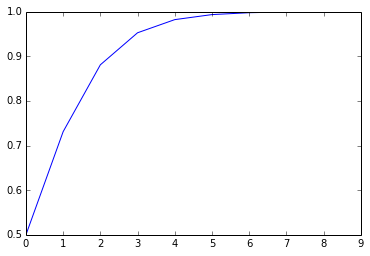

In [14]:
plot(x, sigmoid(x))

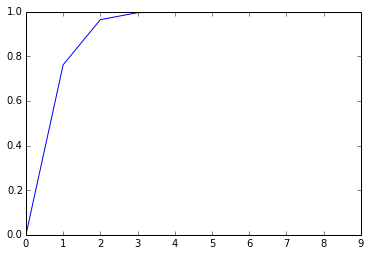

In [15]:
plot(x, np.tanh(x))

In [42]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in xrange(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [71]:
xs, hs, ys, ps = {}, {}, {}, {}
hprev = np.zeros((hidden_size,1))
hs[-1] = np.copy(hprev)
loss = 0

In [72]:
data= [0,1,0,0,1,1,0,0,1]

In [73]:
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 9 characters, 2 unique.


In [74]:
#from https://gist.github.com/karpathy/d4dee566867f8291f086
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [75]:
# hyperparameters
hidden_size = 5 # size of hidden layer of neurons
seq_length = 5 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [77]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print '----\n %s \n----' % (txt, )

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  if n % 100 == 0: print 'iter %d, loss: %f' % (n, smooth_loss) # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

ValueError: matrices are not aligned

In [76]:
#loss function?
for t in xrange(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)

IndexError: list index out of range